In [1]:
import os, sys, glob
from osgeo import gdal
import numpy as np
import matplotlib
import argparse

matplotlib.use("Agg")
import matplotlib.pyplot as plt
from pandas import DataFrame

%matplotlib inline

In [2]:
def get_rasters(indir):
    """Purpose: Construct a string pointing to a specific land cover from-to
    raster, and check to make sure that it exists.

    Args:
        indir = string, the input directory containing the from-to rasters

    Returns:
        in_cl = string, the full path to the input from-to raster file.
    """

    in_cl = glob.glob(indir + os.sep + "*.tif")

    if in_cl is None:

        print("\n**Could not locate input LC Change file for the years specified**\n")

        sys.exit(1)

    return in_cl

In [3]:
def read_data(cl):
    """
    Purpose: Open the Trends from-to LC Change .tif file.
                Iterate through the list of from-to classes.
                Calculate the number of pixels for each from-to class.
                Call the get_trends_area function to calculate the total number
                    of Trends pixels in the tile
    Args:
        cl = string, the full path to the Trends from-to .tif file

    Returns:
        classes = list, the Trends from-to classes
        masked_sum = list, the total number of pixels for each class
        total_pixels = the total number of Trends pixels in the tile
    """

    cl_src = gdal.Open(cl, gdal.GA_ReadOnly)

    cl_data = cl_src.GetRasterBand(1).ReadAsArray()


    """
    # these are valid for the Trends classes
    classes = [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 201, 202,
               203, 204, 205, 206, 207, 208, 209, 210, 211, 301, 302, 303, 304,
               305, 306, 307, 308, 309, 310, 311, 401, 402, 403, 404, 405, 406,
               407, 408, 409, 410, 411, 501, 502, 503, 504, 505, 506, 507, 508,
               509, 510, 511, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610,
               611, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 801,
               802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 901, 902, 903,
               904, 905, 906, 907, 908, 909, 910, 911, 1001, 1002, 1003, 1004,
               1005, 1006, 1007, 1008, 1009, 1010, 1011, 1101, 1102, 1103, 1104,
               1105, 1106, 1107, 1108, 1109, 1110, 1111]
    """
    # Valid for the recoded trends class scheme
    classes = [i * 100 + j for i in range(0,10) for j in range(0,10)]
    # classes = np.unique(cl_data)

    masked_sum = []
    
    for c in classes:

        mask_cl = np.copy(cl_data)

        mask_cl[mask_cl != c] = 0

        mask_cl[mask_cl == c] = 1

        holder = np.sum(mask_cl)

        masked_sum.append(holder)

        # gives an idea of progress for the user
        print(c, " ", holder)

    total_pixels = get_trends_area(cl_data)

    cl_data, cl_src, mask_cl = None, None, None

    return classes, masked_sum, total_pixels


In [4]:
def get_trends_area(data):
    """Purpose:  Calculate the area of coverage by Trends within the ARD tile,
    which will be used to calculate the percentage for each Trends From-To class.

    Args:
        data = numpy array, the input data

    Returns:
        count = integer, the calculated area covered by trends (actually the
        number of trends pixels)
    """

    mask_data = np.copy(data)

    mask_data[mask_data > 0] = 1

    mask_data[mask_data <= 0] = 0

    count = np.sum(mask_data)

    return count

In [5]:
def get_figure(label_set, df, tile, year1, year2):
    """Purpose: Generate a matplotlib figure of n rows and 2 columns, the number
                rows is equal to the number of classes (label_set).  Column 1
                will contain vertical bar charts colored by the 'from' class.
                Column 2 will contain tables showing the count and percent for
                row n 'from' class.
    Args:
        label_set = list of classes
        df = pandas DataFrame object contains class names, counts, and percents
        tile = string, the name of the ARD tile
        year1, year2 = strings, the from and to years
        outname = the output path and filename for the .png image
    Returns:
        None
    """
    
    # Generate figure with length(label_set) rows and 2 columns
    fig, axes = plt.subplots(nrows=len(label_set), ncols=2,
                             figsize=(16, 50))

    # Add figure title
    fig.suptitle("%s Trends %s to %s From-To Classes" % (tile, year1, year2),
                 fontsize=22, fontweight="bold")

    for i, L in enumerate(label_set):

        t = []

        # iterate through rows of dataframe to retrieve values for class L
        for x in df.itertuples():

            if L == '0':

                if len(x[1]) == 1:

                    t.append(x[1:])

            else:

                if x[1][0] == L and len(x[1]) == 3:

                    t.append(x[1:])


                elif x[1][:2] == L and len(x[1]) == 4:

                    t.append(x[1:])

        df_temp = DataFrame(t)

        # print(df_temp)

        # Assign column names
        df_temp.columns = ["Name", "Count", "Percent of Trends Coverage"]

        # generate bar charts in first column for class L in row i
        axes[i, 0].bar(df_temp.index, df_temp.Count)
        axes[i, 0].set_title('"From" Class ' + L + " Bar Chart")
        axes[i, 0].set_xticks(df_temp.index)
        axes[i, 0].set_xticklabels(df_temp.Name)
        axes[i, 0].set_xlabel("Class")
        axes[i, 0].set_ylabel("Count")

        # generate tables in second column for class L in row i
        axes[i, 1].table(cellText=df_temp.values, bbox=[0, 0, 1, 1], colLabels=df_temp.columns)
        axes[i, 1].set_title('"From" Class ' + L + " Table")
        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])

    plt.tight_layout()

    plt.subplots_adjust(top=0.95)

    # save the figure to a .png file
    # plt.savefig(outname, bbox_inches="tight", dpi=150)

    return None

In [6]:
in_dir = r"Z:\eval_materials\sites.prep\h04v02_ref_data\Trends\Recode\LCChange"
tile = "h04v02"

0   25000000
1   20
2   0
3   0
4   472
5   1
6   0
7   0
8   14
9   0
100   240
101   135613
102   7616
103   1184
104   4415
105   27
106   66
107   0
108   0
109   0
200   446
201   5067
202   149053
203   7559
204   1070
205   159
206   307
207   0
208   3
209   8
300   620
301   599
302   1824
303   277345
304   16727
305   0
306   113
307   0
308   194
309   143
400   2333
401   16887
402   1076
403   7608
404   951540
405   192
406   900
407   0
408   1599
409   38050
500   38
501   22
502   193
503   0
504   161
505   15234
506   70
507   0
508   28
509   0
600   28
601   31
602   84
603   54
604   934
605   78
606   13673
607   0
608   468
609   11
700   0
701   0
702   0
703   0
704   0
705   0
706   0
707   70319
708   0
709   0
800   40
801   1
802   0
803   133
804   2279
805   17
806   157
807   0
808   65529
809   18
900   93
901   2894
902   0
903   25381
904   29172
905   0
906   153
907   0
908   2
909   596


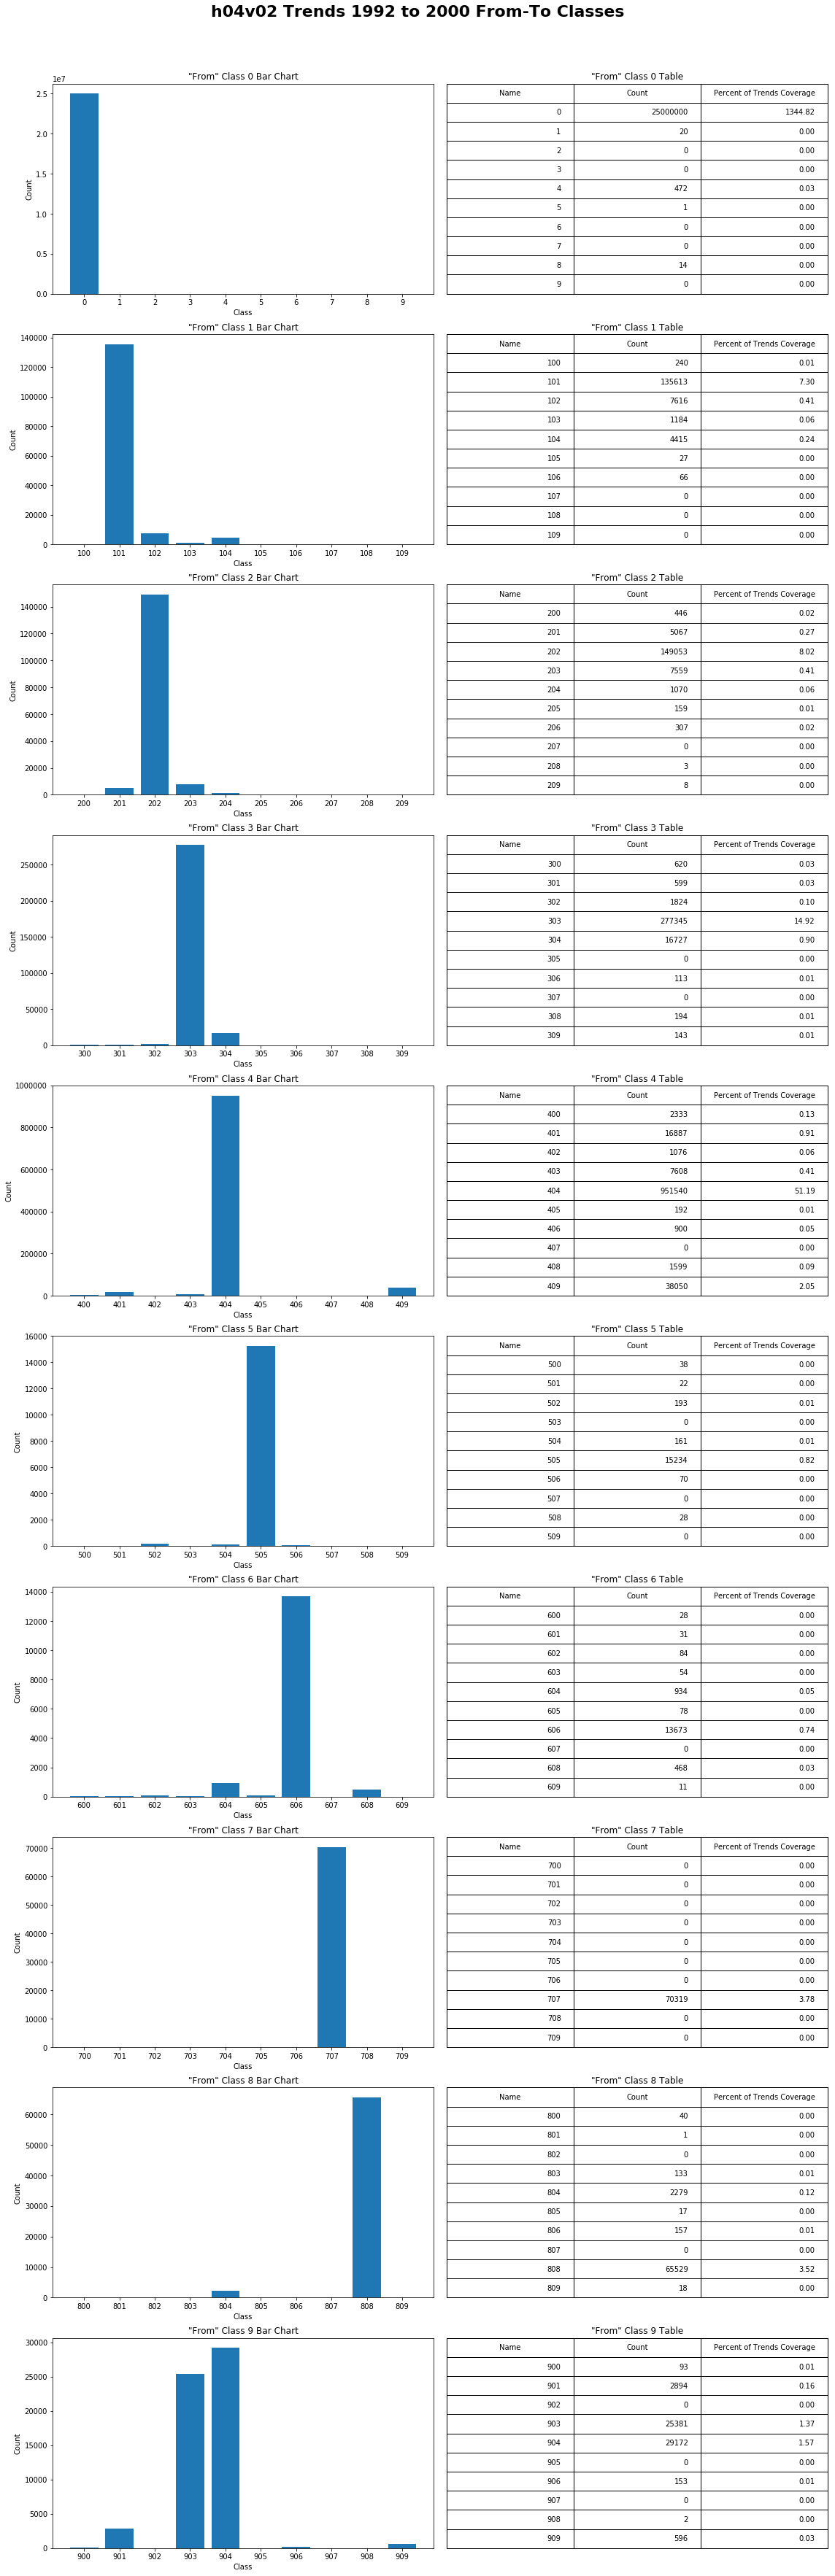

In [7]:
in_files = get_rasters(in_dir)

for in_cl in in_files:

    year1 = in_cl[-16:-12]

    year2 = in_cl[-10:-6]

    # outname = "%s%s%strends%sto%s_lchange.png" % (out_dir, os.sep, tile, year1, year2)

    classes, class_sums, total = read_data(in_cl)

    # calculate the percent of the total for each from-to class
    class_perc = ["%.2f" % (val / float(total) * 100.0) for val in class_sums]

    # convert the items in classes list to strings and save in a new list
    labels = [str(c) for c in classes]

    # get a set of the unique "from" classes (the first 1 or 2 digits)
    labels_ = [l[0] if len(l) == 3 else 0 if len(l) == 1 else l[:2] for l in labels]

    label_set = set(labels_)  # converting to set removes duplicates

    label_set = list(label_set)  # convert back to list to allow indexing

    # Cluttered way to return a list of class values with the correct order
    label_set = [int(l) for l in label_set]

    label_set.sort()

    label_set = [str(l) for l in label_set]

    # create list of tuples to populate three data columns
    data = [(x, y, z) for x, y, z in zip(labels, class_sums, class_perc)]

    # create pandas dataframe from the list of tuples
    df = DataFrame(data)

    # add column names to the dataframe
    df.columns = ["Name", "Count", "Percent"]

    get_figure(label_set, df, tile, year1, year2)
    break

In [8]:
print(classes, len(classes))
print(class_sums, len(class_sums))
print(class_perc, len(class_perc))
print(labels, len(labels))
print(labels_, len(labels_))
print(label_set, len(label_set))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909] 100
[25000000, 20, 0, 0, 472, 1, 0, 0, 14, 0, 240, 135613, 7616, 1184, 4415, 27, 66, 0, 0, 0, 446, 5067, 149053, 7559, 1070, 159, 307, 0, 3, 8, 620, 599, 1824, 277345, 16727, 0, 113, 0, 194, 143, 2333, 16887, 1076, 7608, 951540, 192, 900, 0, 1599, 38050, 38, 22, 193, 0, 161, 15234, 70, 0, 28, 0, 28, 31, 84, 54, 934, 78, 13673, 0, 468, 11, 0, 0, 0, 0, 0, 0, 0, 70319, 0, 0, 40, 1, 0, 133, 2279, 17, 157, 0, 65529, 18, 93, 2894, 0, 25381, 29172, 0, 153, 0, 2, 596] 100
['1344.82', '0.00', '0.00', '0.00', '0.03', '0.00'